In [98]:
# We are setting up the enviornment

# for random number functions and system-specific parameters.
import random
import sys
# Pygame is a library used to create video games.
import pygame
from pygame.locals import *
# for numerical computations (we are using to create Q-table)
import numpy
# for plotting graphs and visualize the results
import matplotlib.pyplot as plt

# variables set the screen width and height for the game window
SW = 280
SH = 511
# vertical position (likely the ground level) at 80% of the screen height
BASEY = SH *0.8
IMAGES = {}
# Initializes the font module in pygame
pygame.font.init()
# the main window (or screen) for the game
WINDOW = pygame.display.set_mode((SW,SH))
Font = pygame.font.SysFont("comicsans",30)
PIPE = '/content/pipe.png'
BG = '/content/bg.png'
BIRD = '/content/bird1.png'
BASE = '/content/base.png'
# creates a 3-dimensional NumPy array filled with zeros
Q=numpy.zeros((7,21,2),dtype = float)
# Frame rate setup - sets the frames per second for the game. This means the game loop is intended
# to update 32 times every second.
FPS = 32


In [99]:
# defines the bird's postion (horizontal, vertical) - (x,y)
#
def static():
	birdxpos = int(SW/5)
	birdypos = int((SH - IMAGES['bird'].get_height())/2)
	basex = 0
# event handling
	while (True):
		for event in pygame.event.get():
			# If the user tries to close the window, the game exits
			if event.type == QUIT:
				pygame.quit()
				sys.exit()
# start the game whenever right key is pressed
			elif event.type == KEYDOWN and (event.key == K_SPACE or event.key == K_UP):
				return
			# display of the screen
			else :
				WINDOW.blit(IMAGES['background'],(0,0))
				WINDOW.blit(IMAGES['bird'],(birdxpos,birdypos))
				WINDOW.blit(IMAGES['base'],(basex,BASEY))
				text1 = Font.render("Flappy Bird Game",1,(255,255,255))
				WINDOW.blit(text1,(SW/2 ,SH/2))
				pygame.display.update()
				FPSCLOCK.tick(FPS)


In [100]:
def game_start(generation,x,y,alpha):
	# generation = trial number
	score = 0
	birdxpos = int(SW/5)
	birdypos = int(SH/2)
	basex1 = 0
	basex2 = SW

	bgx1=0
	bgx2 = IMAGES['background'].get_width()

	newPipe1 = get_new_pipe()
	newPipe2 = get_new_pipe()

	up_pipes = [
	{'x':SW +200,'y': newPipe1[0]['y']},
	{'x':SW +500 ,'y': newPipe2[0]['y']}
	]

	bttm_pipes = [
	{'x':SW+200,'y':newPipe1[1]['y']},
	{'x':SW +500 ,'y': newPipe2[1]['y']}
	]

	pipeVelx = -4
# Initial upward velocity
	birdyvel = -9
# Maximum downward speed
	birdymaxvel = 10
# Minimum upward speed
	birdyvelmin = -8
# acceleration (gravity) that increases the bird’s downward speed
	birdyacc = 1
# acceleration given to the bird when a flap occurs
	playerFlapAccv = -8
# A flag to check if the bird flapped
	playerFlapped =False
# loop which continues until a collision (crash) happens
	while(True):
# the bird’s current position
                # into a state representation usable by
                # the Q-learning algorithm
		x_prev,y_prev = convert(birdxpos,birdypos,bttm_pipes)
	#  uses the current state to decide whether the bird should flap or not
		jump = ai_play(x_prev,y_prev)

		for event in pygame.event.get():
			if event.type == QUIT:
				plt.scatter(x,y)
				plt.xlabel("GENERATION/Number of Trials")
				plt.ylabel("SCORE")
				plt.title("Flappy Birds : AI Project")
				plt.show()
				pygame.quit()
				sys.exit()

# when flap happened
		if jump:
			if birdypos>0:
				birdyvel = playerFlapAccv
				playerFlapped = True





		playerMidPos= birdxpos + IMAGES['bird'].get_width()/2
		for pipe in up_pipes:
			pipeMidPos = pipe ['x'] +IMAGES['pipe'][0].get_width()/2
			if pipeMidPos <= playerMidPos < pipeMidPos +4 :
				score += 1


		if birdyvel < birdymaxvel and not playerFlapped:
			birdyvel += birdyacc


		if playerFlapped:
			playerFlapped = False

		playerHeight = IMAGES['bird'].get_height()

		birdypos = birdypos + min (birdyvel, BASEY - birdypos -playerHeight)
# Moving Pipes and new pipe generation
		for upperPipe,lowerPipe in zip(up_pipes,bttm_pipes):
			upperPipe['x'] += pipeVelx
			lowerPipe['x'] += pipeVelx

		if (0<up_pipes[0]['x']<5):
			newPipe = get_new_pipe()
			up_pipes.append(newPipe[0])
			bttm_pipes.append(newPipe[1])
# Removing Off-screen Pipes
		if(up_pipes[0]['x'] < -IMAGES['pipe'][0].get_width() ):
			up_pipes.pop(0)
			bttm_pipes.pop(0)
		basex1-=4
		basex2-=4
		if(basex1 <= -IMAGES['base'].get_width()):
			basex1 = basex2
			basex2 = basex1 + IMAGES['base'].get_width()

		bgx1-=2
		bgx2-=2
		if(bgx1 <= -IMAGES['background'].get_width()):
			bgx1 = bgx2
			bgx2 = bgx1 + IMAGES['background'].get_width()
		crashTest = Collision(birdxpos,birdypos,up_pipes,bttm_pipes)
		x_new,y_new = convert(birdxpos,birdypos,bttm_pipes)
	# Collision Detection and reward assignment
		if crashTest:
			reward = -1000
			Q_update(x_prev,y_prev,jump,reward,x_new,y_new, alpha)
			return score

		reward = 15
# State Update and Q-learning
		Q_update(x_prev,y_prev,jump,reward,x_new,y_new, alpha)

# Display Update and Frame Control
		WINDOW.blit(IMAGES['background'],(bgx1,0))
		WINDOW.blit(IMAGES['background'],(bgx2,0))
		for upperPipe,lowerPipe in zip(up_pipes,bttm_pipes):
			WINDOW.blit(IMAGES['pipe'][0],(upperPipe['x'],upperPipe['y']))
			WINDOW.blit(IMAGES['pipe'][1],(lowerPipe['x'],lowerPipe['y']))
		WINDOW.blit(IMAGES['base'],(basex1,BASEY))
		WINDOW.blit(IMAGES['base'],(basex2,BASEY))
		text1 = Font.render("Score: "+ str(score),1,(255,255,255))
		text2 = Font.render("Generation: "+ str(generation),1,(255,255,255))
		WINDOW.blit(text1,(SW - 10 -text1.get_width(),10))
		WINDOW.blit(text2,(0,0))
		WINDOW.blit(IMAGES['bird'],(birdxpos,birdypos))

		pygame.display.update()
		FPSCLOCK.tick()

In [101]:
def Collision(birdxpos,birdypos,up_pipes,bttm_pipes):
	# checking for Ground Collision or Ceiling Collision
	# if the one of them happened then returns True, indicating a collision
	if (birdypos >= BASEY - IMAGES['bird'].get_height() or birdypos < 0):
		return True
	# checking upper pipe collision
	for pipe in up_pipes:
		pipeHeight = IMAGES['pipe'][0].get_height()
		if(birdypos < pipeHeight + pipe['y'] and abs(birdxpos - pipe['x']) < IMAGES['pipe'][0].get_width()):
			return True
# checking lower pipe collision
	for pipe in bttm_pipes:
		if (birdypos + IMAGES['bird'].get_height() > pipe['y'] and abs(birdxpos - pipe['x']) < IMAGES['pipe'][0].get_width()):
			return True
	# if nothing of the above happened then return no collision
	return False


In [102]:
# function generates a new pair of pipes (one upper and one lower) for the Flappy Bird game
def get_new_pipe():
# vertical gap between the upper and lower pipes is set as one-fourth of the SH
	pipeHeight = IMAGES['pipe'][1].get_height()
	gap = int(SH/4)
	y2 = int(gap + random.randrange(0,int(SH - IMAGES['base'].get_height() - 1.2*gap)))
 # x,y postions for pipe
	pipex = int(SW+300 )
	y1 = int(pipeHeight -y2 +gap)

# Create and Return the Pipe Pair
	pipe = [
	{'x':pipex,'y':-y1},
	{'x':pipex,'y':y2}
	]
	return pipe


In [103]:
# agent making the decesion to flap or not
def ai_play(x,y):
# initializes a variable max (which holds the highest Q-value for the
        # current state) and a boolean flag jump set to False
	max=0
	jump = False
# The Q-table have two actions, the function compares these two values
	if(Q[x][y][1]>Q[x][y][0]):
		max = Q[x][y][1]
		jump =True

	return jump

# This function converts the bird’s and the nearest lower pipe’s positions
# into discrete state indices that are used to
# access Q-table.
def convert(birdxpos,birdypos,bttm_pipes):
	x = min(280, bttm_pipes[0]['x'])
	y = bttm_pipes[0]['y']-birdypos
	if(y<0):
		y=abs(y)+408
	return int(x/40-1),int(y/40)


In [104]:
# Using Q-learning algprithm
# updating the Q-value
def Q_update(x_prev,y_prev,jump,reward,x_new,y_new, alpha):


	if jump:
		Q[x_prev][y_prev][1] =(1-alpha) * Q[x_prev][y_prev][1] + alpha *(reward+max(Q[x_new][y_new][0],Q[x_new][y_new][1]))
	else :
		Q[x_prev][y_prev][0] = (1-alpha) * Q[x_prev][y_prev][0] + alpha *(reward+max(Q[x_new][y_new][0],Q[x_new][y_new][1]))



In [105]:
# Main function for output
if __name__ == "__main__":
    pygame.init()
    FPSCLOCK = pygame.time.Clock()
    pygame.display.set_caption("AI PROJECT")

    # Load images
    IMAGES['base'] = pygame.image.load('/content/base.png').convert_alpha()
    IMAGES['pipe'] = (pygame.transform.rotate(pygame.image.load(PIPE).convert_alpha(), 180),
                      pygame.image.load(PIPE).convert_alpha())
    IMAGES['background'] = pygame.image.load(BG).convert()
    IMAGES['bird'] = pygame.image.load(BIRD).convert_alpha()

    # Different learning rates to test
    alpha_values = [0.2, 0.4, 0.6, 0.9]
    max_generations = 30

    # Store results for each alpha
    results = {}

    for alpha in alpha_values:
        print(f"\n==== Training for alpha={alpha} ====\n")

        x = []
        y = []
        generation = 1

        while generation <= max_generations:
            score = game_start(generation, x, y, alpha)

            if score == -1:  # Handle crashes
                print(f"Game crashed at generation {generation} for alpha={alpha}")
                break

            x.append(generation)
            y.append(score)

            # Print last scores
            print(f"Alpha={alpha} | Generation: {generation} | Score: {score}")

            generation += 1

        results[alpha] = (x, y)  # Store results for plotting




==== Training for alpha=0.2 ====

Alpha=0.2 | Generation: 1 | Score: 0
Alpha=0.2 | Generation: 2 | Score: 0
Alpha=0.2 | Generation: 3 | Score: 0
Alpha=0.2 | Generation: 4 | Score: 0
Alpha=0.2 | Generation: 5 | Score: 0
Alpha=0.2 | Generation: 6 | Score: 0
Alpha=0.2 | Generation: 7 | Score: 0
Alpha=0.2 | Generation: 8 | Score: 0
Alpha=0.2 | Generation: 9 | Score: 0
Alpha=0.2 | Generation: 10 | Score: 0
Alpha=0.2 | Generation: 11 | Score: 1
Alpha=0.2 | Generation: 12 | Score: 0
Alpha=0.2 | Generation: 13 | Score: 0
Alpha=0.2 | Generation: 14 | Score: 0
Alpha=0.2 | Generation: 15 | Score: 0
Alpha=0.2 | Generation: 16 | Score: 0
Alpha=0.2 | Generation: 17 | Score: 0
Alpha=0.2 | Generation: 18 | Score: 0
Alpha=0.2 | Generation: 19 | Score: 0
Alpha=0.2 | Generation: 20 | Score: 0
Alpha=0.2 | Generation: 21 | Score: 2
Alpha=0.2 | Generation: 22 | Score: 0
Alpha=0.2 | Generation: 23 | Score: 0
Alpha=0.2 | Generation: 24 | Score: 0
Alpha=0.2 | Generation: 25 | Score: 0
Alpha=0.2 | Generation: 


=== Average Scores Summary ===

Alpha=0.2 -> Average Score: 0.10
Alpha=0.4 -> Average Score: 5.43
Alpha=0.6 -> Average Score: 33.77
Alpha=0.9 -> Average Score: 27.33


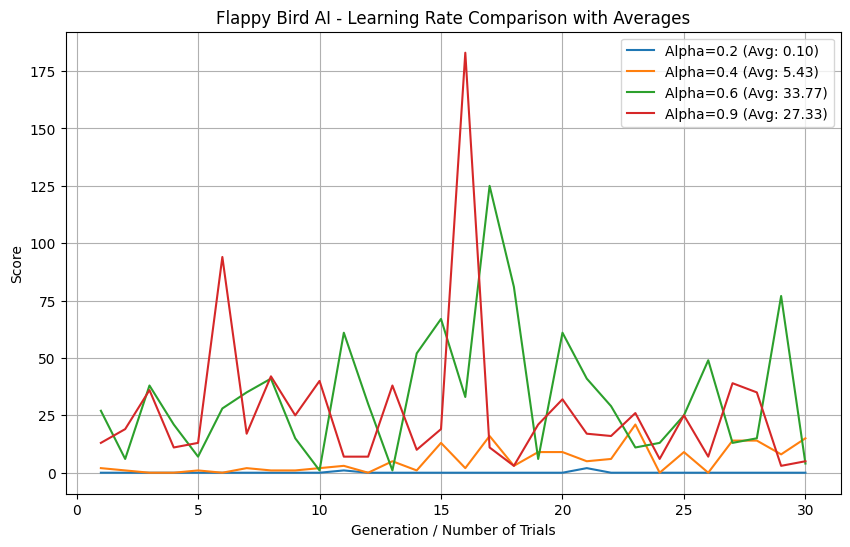

In [106]:
# print average scores for each alpha
print("\n=== Average Scores Summary ===\n")

average_scores = {}  # Store average scores for each alpha

for alpha, (x, y) in results.items():
    avg_score = np.mean(y)
    average_scores[alpha] = avg_score
    print(f"Alpha={alpha} -> Average Score: {avg_score:.2f}")

# Plotting scores over generations for each alpha
plt.figure(figsize=(10, 6))

for alpha, (x, y) in results.items():
    plt.plot(x, y, label=f"Alpha={alpha} (Avg: {average_scores[alpha]:.2f})")

plt.xlabel("Generation / Number of Trials")
plt.ylabel("Score")
plt.title("Flappy Bird AI - Learning Rate Comparison with Averages")
plt.legend()
plt.grid(True)
plt.show()
